In [2]:
import xarray
import cartopy
import matplotlib.pyplot as mp
import numpy
import pandas
import calendar
import datetime
import itertools
import scipy.signal
import cmocean
import netCDF4
import glob

In [3]:
#gpcp_monthly_filename = '/Users/baird/Dropbox/_data_observations/GPCP/precip.mon.mean.nc'
trmm_daily_directory = '/beegfs/DATA/pritchard/blangenb/TRMM_DATA/'

In [4]:
lat_lo = -25
lat_hi = 25
lon_lo = 85
lon_hi = 160

In [5]:
file_list = sorted(glob.glob(trmm_daily_directory+'/'+'*1998*nc4'))
ds_list = [netCDF4.Dataset(file) for file in file_list]

In [7]:
lat = numpy.array(ds_list[0]['lat'])
lon = numpy.array(ds_list[0]['lon'])

lat_indices = (lat>=lat_lo) & (lat<=lat_hi)
lon_indices = (lon>=lon_lo) & (lon<=lon_hi)

In [8]:
trmm_data = [numpy.array(i['precipitation'])[lon_indices,:][:,lat_indices] for i in ds_list]

In [165]:
file_list_ALL = numpy.array(sorted(glob.glob(trmm_daily_directory+'/'+'*nc4')))
trmm_datetime = numpy.array([datetime.datetime.strptime(f.split('/')[-1].split('.')[1], '%Y%m%d') for f in file_list_ALL])

In [119]:
trmm_data_list = []
for i in range(file_list_ALL.size):
    if i==0:
        print(trmm_datetime[i])
    else:
        if trmm_datetime[i].year!=trmm_datetime[i-1].year:
            print(trmm_datetime[i])
    ds = netCDF4.Dataset(file_list_ALL[i])
    trmm_data = numpy.array(ds['precipitation'][lon_indices,:][:,lat_indices])
    ds.close()
    trmm_data_list.append(trmm_data)

1998-01-01 00:01:00
1999-01-01 00:01:00
2000-01-01 00:01:00
2001-01-01 00:01:00
2002-01-01 00:01:00
2003-01-01 00:01:00
2004-01-01 00:01:00
2005-01-01 00:01:00
2006-01-01 00:01:00
2007-01-01 00:01:00
2008-01-01 00:01:00
2009-01-01 00:01:00
2010-01-01 00:01:00
2011-01-01 00:01:00
2012-01-01 00:01:00
2013-01-01 00:01:00
2014-01-01 00:01:00
2015-01-01 00:01:00
2016-01-01 00:01:00
2017-01-01 00:01:00
2018-01-01 00:01:00


In [121]:
trmm_data = numpy.array(trmm_data_list)

In [196]:
trmm_data[trmm_data<0] = numpy.nan

In [123]:
nino34_filename = '/beegfs/DATA/pritchard/blangenb/NINO34_INDEX/nino34_index.txt'
nino34_df = pandas.read_csv(nino34_filename, skiprows=1, skipfooter=3, header=None, delim_whitespace=True)
nino34_data = nino34_df.values[:,1:].flatten()
nino34_data[nino34_data==-99.99]=numpy.nan

/export/home/blangenb/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  


In [124]:
year_start = nino34_df[0].values[0]
year_end = nino34_df[0].values[-1]

nino34_datetime_list = []
for y,m in list(itertools.product(range(year_start,year_end+1),range(1,13))):
    nino34_datetime_list.append(datetime.date(y,m,15))
nino34_datetimes = numpy.array(nino34_datetime_list)

In [125]:
nino34_data_NaNs = numpy.zeros((nino34_data.shape), dtype=bool)
nino34_data_NaNs[~numpy.isnan(nino34_data)]=1
nino34_data_filtered = nino34_data[nino34_data_NaNs]
nino34_datetimes_filtered = nino34_datetimes[nino34_data_NaNs]

In [126]:
nino34_data_detrend = scipy.signal.detrend(nino34_data_filtered)
nino34_data_centered = nino34_data_detrend-nino34_data_detrend.mean()

### Definition of El Nino/La Nina:

The index is defined as a three-month average of sea surface temperature departures from normal for a critical region of the equatorial Pacific (Niño 3.4 region; 120W-170W, 5N-5S). This region of the tropical Pacific contains what scientists call the "equatorial cold tongue," a band of cool water that extends along the equator from the coast of South America to the central Pacific Ocean. Departures from average sea surface temperatures in this region are critically important in determining major shifts in the pattern of tropical rainfall, which influence the jet streams and patterns of temperature and precipitation around the world.

North America's operational definitions for El Niño and La Niña, based on the index, are:
El Niño: A phenomenon in the equatorial Pacific Ocean characterized by a positive sea surface temperature departure from normal (for the 1971-2000 base period) in the Niño 3.4 region greater than or equal in magnitude to 0.5 degrees C (0.9 degrees Fahrenheit), averaged over three consecutive months.

La Niña: A phenomenon in the equatorial Pacific Ocean characterized by a negative sea surface temperature departure from normal (for the 1971-2000 base period) in the Niño 3.4 region greater than or equal in magnitude to 0.5 degrees C (0.9 degrees Fahrenheit), averaged over three consecutive months.

In [127]:
nino34_data_final = pandas.Series(nino34_data_centered).rolling(window=3, center=True).mean()

plot

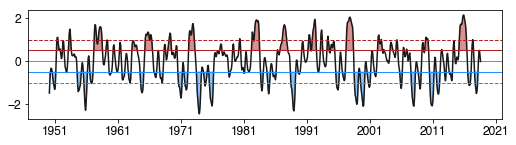

In [128]:
fontsize = 12

fig = mp.figure(figsize=(8.5,2))

x = nino34_datetimes_filtered
y2 = nino34_data_final

ax = fig.add_subplot(111)
ax.plot(x, y2, c='0.1')

ax.axhline(0, lw=0.5, ls='-', c='0.1')
ax.axhline(0.5, lw=1, ls='-', c='firebrick')
ax.axhline(-0.5, lw=1, ls='-', c='dodgerblue')

ax.axhline(1, lw=1, ls='--', c='firebrick')
ax.axhline(-1, lw=1, ls='--', c='dodgerblue')

y1_positive = numpy.ones((nino34_data_final.size))*0.5
y1_negative = numpy.ones((nino34_data_final.size))*-0.5

ax.fill_between(x, y1_positive, y2, where=y2>=y1_positive, color='firebrick', alpha='0.5')
ax.fill_between(x, y1_negative, y2, where=y2<=y1_negative, color='dodgerblue', alpha='0.5')

ax.tick_params(labelsize=fontsize)

define weak el nino as >=0.5 and <1.0  
strong el nino as >= 1.0

In [129]:
elnino_weak = (nino34_data_final>0.5) & (nino34_data_final<=1.0)
elnino_strong = (nino34_data_final>1.0)

lanina_weak = (nino34_data_final<-0.5) & (nino34_data_final>=-1.0)
lanina_strong = (nino34_data_final<-1.0)

elnino_all = (nino34_data_final>0.5)
lanina_all = (nino34_data_final<-0.5)

enso_neutral = (nino34_data_final>-0.5)&(nino34_data_final<0.5)

For a given index, pick out precip data when it's Aug, Sept, Oct AND corresponds to the index, then take stdev

In [130]:
lanina_all_dates = nino34_datetimes_filtered[lanina_all]
elnino_all_dates = nino34_datetimes_filtered[elnino_all]

In [167]:
# calculate el nino indices
trmm_dt_elnino_indices = []
date_tuples = [(t.year,t.month) for t in elnino_all_dates]
for t in trmm_datetime:
    if (t.year,t.month) in date_tuples:
        trmm_dt_elnino_indices.append(True)
    else:
        trmm_dt_elnino_indices.append(False)
trmm_dt_elnino_indices = numpy.array(trmm_dt_elnino_indices)

In [168]:
# calculate la nina indices
trmm_dt_lanina_indices = []
date_tuples = [(t.year,t.month) for t in lanina_all_dates]
for t in trmm_datetime:
    if (t.year,t.month) in date_tuples:
        trmm_dt_lanina_indices.append(True)
    else:
        trmm_dt_lanina_indices.append(False)
trmm_dt_lanina_indices = numpy.array(trmm_dt_lanina_indices)

# calculate ASO stdev

In [225]:
months = list(range(1,13))

In [226]:
# count number of months in each
trmm_lanina_months_indices = []
for t,boolean in zip(trmm_datetime,trmm_dt_lanina_indices):
    if (t.month in months) & (boolean==True):
        trmm_lanina_months_indices.append(True)
    else:
        trmm_lanina_months_indices.append(False)

In [227]:
trmm_elnino_months_indices = []
for t,boolean in zip(trmm_datetime,trmm_dt_elnino_indices):
    if (t.month in months) & (boolean==True):
        trmm_elnino_months_indices.append(True)
    else:
        trmm_elnino_months_indices.append(False)

In [228]:
trmm_lanina_months_stdev = numpy.nanstd(trmm_data[trmm_lanina_months_indices,:,:], axis=0, ddof=1)
trmm_elnino_months_stdev = numpy.nanstd(trmm_data[trmm_elnino_months_indices,:,:], axis=0, ddof=1)

In [229]:
trmm_lanina_months_mean = numpy.nanmean(trmm_data[trmm_lanina_months_indices,:,:], axis=0)
trmm_elnino_months_mean = numpy.nanmean(trmm_data[trmm_elnino_months_indices,:,:], axis=0)

In [202]:
trmm_stdev = numpy.nanstd(trmm_data, axis=0, ddof=1)

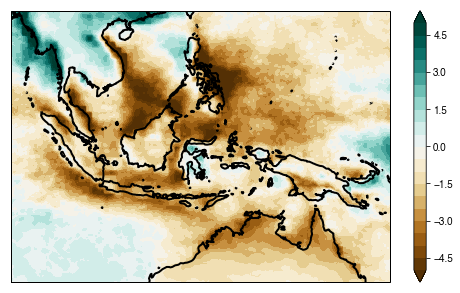

In [230]:
map_proj = cartopy.crs.PlateCarree()
data_proj = cartopy.crs.PlateCarree()

clevels = numpy.arange(-5,5.1,0.5)

fig = mp.figure(figsize=(8.5,5))
ax = fig.add_subplot(111, projection=map_proj)
plot = ax.contourf(lon[lon_indices],lat[lat_indices],trmm_elnino_months_mean.T-trmm_lanina_months_mean.T,\
            transform=data_proj,extend='both',cmap='BrBG',levels=clevels)
ax.coastlines(resolution='50m', lw=2)

ax.set_extent([90,155,-20,20])
fig.colorbar(plot)

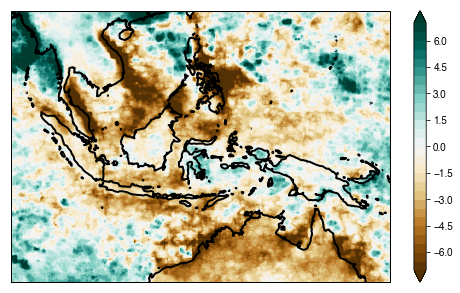

In [231]:
map_proj = cartopy.crs.PlateCarree()
data_proj = cartopy.crs.PlateCarree()

clevels = numpy.arange(-7,7.1,0.5)

fig = mp.figure(figsize=(8.5,5))
ax = fig.add_subplot(111, projection=map_proj)
plot = ax.contourf(lon[lon_indices],lat[lat_indices],trmm_elnino_months_stdev.T-trmm_lanina_months_stdev.T,\
            transform=data_proj,extend='both',cmap='BrBG',levels=clevels)
ax.coastlines(resolution='50m', lw=2)

ax.set_extent([90,155,-20,20])
fig.colorbar(plot)

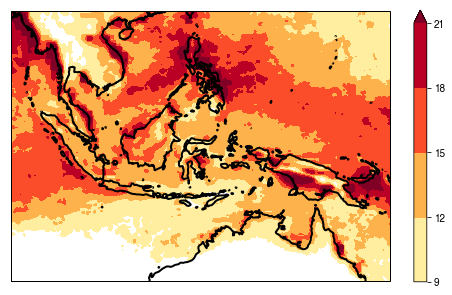

In [232]:
map_proj = cartopy.crs.PlateCarree()
data_proj = cartopy.crs.PlateCarree()

clevels = numpy.arange(9,23.1,3)

fig = mp.figure(figsize=(8.5,5))
ax = fig.add_subplot(111, projection=map_proj)
plot = ax.contourf(lon[lon_indices],lat[lat_indices],trmm_stdev.T,\
            transform=data_proj,extend='max',cmap='YlOrRd',levels=clevels)
ax.coastlines(resolution='50m', lw=2)

ax.set_extent([90,155,-20,20])
fig.colorbar(plot)